In [1]:
%load_ext autoreload
%autoreload 2

# CEO-Request Challenge

In [2]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from olist.order import Order
orders = Order().get_training_data(with_distance_seller_customer=True)
orders.head()

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_items,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72,18.063837
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76,856.292580
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered,1,0,5,1,1,159.90,19.22,514.130333
3,949d5b44dbf5de918fe9c16f97b45f8a,13.208750,26.188819,0.0,delivered,1,0,5,1,1,45.00,27.20,1822.800366
4,ad21c59c0840e6cb83a9ceb5573f8159,2.873877,12.112049,0.0,delivered,1,0,5,1,1,19.90,8.72,30.174037


In [4]:
from olist.seller import Seller
sellers = Seller().get_training_data()
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70,421.870,281.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07,2370.307,2130.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00,95.800,95.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99,87.999,87.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99,96.799,-3.201


## 1. Summary of Problem Statement

❓ **How could Olist improve its profit** ❓

### P&L Rules

#### Revenues  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  
**Subscription fees:** Olist charges **80 BRL per month** per seller

#### Costs
_Estimated_ **reputation costs** of orders with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We make an assumption about the monetary cost for each bad review:
```python
# review_score: cost(BRL)
{'1 star': 100
 '2 stars': 50
 '3 stars': 40
 '4 stars': 0
 '5 stars': 0}
```

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that have ever joined the platform, as well as with the square root of the total cumulated number of items that were ever sold.

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items}$  
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both the number of sellers to manage and the number of sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that Olist has a lower IT Cost with few sellers selling a lot of items rather than the opposite  
- with **1000 sellers** and a total of **100 items** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 items** sold, the total IT cost accumulates to 62,507 BRL

Finally, The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to **500,000 BRL**.

In [5]:
orders_copy = orders.copy()
sellers_copy = sellers.copy()

In [6]:
sellers_copy['sales_fee'] = sellers_copy['sales'] * 0.10
sellers_copy.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits,sales_fee
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70,421.870,281.870,21.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07,2370.307,2130.307,1170.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00,95.800,95.800,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99,87.999,87.999,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99,96.799,-3.201,16.799


In [7]:
sellers_copy['subscription_fees'] = (sellers_copy['months_on_olist'] + 1) * 80
sellers_copy.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits,sales_fee,subscription_fees
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70,421.870,281.870,21.870,400.0
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07,2370.307,2130.307,1170.307,1200.0
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00,95.800,95.800,15.800,80.0
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99,87.999,87.999,7.999,80.0
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99,96.799,-3.201,16.799,80.0


In [8]:
review_score ={
    1: 100,
    2: 50,
    3: 40,
    4: 0,
    5: 0
}
orders_copy['reputation_cost'] = orders_copy['review_score'].map(review_score)
orders_copy

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_items,number_of_sellers,price,freight_value,distance_seller_customer,reputation_cost
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72,18.063837,0
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76,856.292580,0
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered,1,0,5,1,1,159.90,19.22,514.130333,0
3,949d5b44dbf5de918fe9c16f97b45f8a,13.208750,26.188819,0.0,delivered,1,0,5,1,1,45.00,27.20,1822.800366,0
4,ad21c59c0840e6cb83a9ceb5573f8159,2.873877,12.112049,0.0,delivered,1,0,5,1,1,19.90,8.72,30.174037,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95875,9c5dedf39a927c1b2549525ed64a053c,8.218009,18.587442,0.0,delivered,1,0,5,1,1,72.00,13.08,69.481037,0
95876,63943bddc261676b46f01ca7ac2f7bd8,22.193727,23.459051,0.0,delivered,0,0,4,1,1,174.90,20.10,474.098245,0
95877,83c1379a015df1e13d02aae0204711ab,24.859421,30.384225,0.0,delivered,1,0,5,1,1,205.99,65.02,968.051192,0
95878,11c177c8e97725db2631073c19f07b62,17.086424,37.105243,0.0,delivered,0,0,2,2,1,359.98,81.18,370.146853,50


In [9]:
alpha = 3157.27
beta = 978.23

In [10]:
n_sellers = sellers_copy['seller_id'].nunique() #Usar len() count() tambien funciona
n_sellers

2967

In [11]:
n_items = orders_copy['number_of_items'].sum()
n_items

109465

In [12]:
it_costs = alpha * np.sqrt(n_sellers) + beta * np.sqrt(n_items)
it_costs

495629.2912348197

### Key Findings, so far

- `wait_time` is the most significant factor behind low review scores.
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`.
- Because the carrier's delivery time is out of Olist's direct control, improving it is not a quick-win recommendation.
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.
- Comments in the bad reviews showed that some were linked to the seller or to the product itself.

💡 We recommend you to start with the the guided seller analysis in part 2 below.

💪 But feel free to investigate other hypothesis instead with part 3.

## 2. Should Olist remove under-performing sellers from its marketplace? 🕵🏻
*(recommended)*

To analyze the impact of removing the worst sellers from Olist's marketplace, we will perform a **what-if analysis**

👉 **What would have happened if Olist had never accepted these sellers in the first place?**  

*(In practice, it's hard to know in advance who is a good seller, but let's start with this approach and iterate later).*

### 2.1 Data Preparation

Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` the seller brings
- the `review_costs` associated with the seller's bad reviews
- the resulting `profits` (revenues - costs)

👉 Write down a step-by-step strategy to create the DataFrame you need.


⚠️ Don't start from scratch, update your existing package! 😉

Starting from the `Seller` class of your `olist` package:

Edit the `get_training_data` method so that the DataFrame it returns contains the fields:
- `revenues`: sum of subscription and sales fees revenues
- `cost_of_reviews`: sum of costs associated with bad reviews
- `profits`: `revenues` - `cost_of_reviews`

In [13]:
sellers_copy['revenues'] = sellers_copy['sales_fee'] + sellers_copy['subscription_fees']
sellers_copy

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits,sales_fee,subscription_fees
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000000,218.70,421.870,281.870,21.870,400.0
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025000,11703.07,2370.307,2130.307,1170.307,1200.0
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000000,158.00,95.800,95.800,15.800,80.0
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0,1,1,1.000000,79.99,87.999,87.999,7.999,80.0
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,1.00,100,1,1,1.000000,167.99,96.799,-3.201,16.799,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,98dddbc4601dd4443ca174359b237166,sarandi,PR,0.000000,8.230822,2018-07-14 03:10:19,2018-07-23 15:34:03,0.0,0.000000,1.000000,5.00,0,2,2,1.000000,158.00,95.800,95.800,15.800,80.0
2963,f8201cab383e484733266d1906e2fdfa,palhoca,SC,0.000000,13.045797,2017-06-17 15:30:11,2018-08-11 19:55:17,14.0,0.100000,0.500000,4.10,140,10,10,1.000000,889.00,1288.900,1148.900,88.900,1200.0
2964,74871d19219c7d518d0090283e03c137,sao paulo,SP,0.000000,3.606625,2018-04-05 17:09:46,2018-08-21 19:25:15,5.0,0.000000,1.000000,5.00,0,6,7,1.166667,550.04,535.004,535.004,55.004,480.0
2965,e603cf3fec55f8697c9059638d6c8eb5,pelotas,RS,0.000000,6.657634,2017-02-09 02:43:17,2017-06-16 17:30:16,4.0,0.000000,0.500000,4.25,50,8,11,1.375000,297.00,429.700,379.700,29.700,400.0


In [14]:
from olist.data import Olist
olist = Olist()
data = olist.get_data()
olist_order_items_dataset = data['order_items']
olist_order_items_dataset.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [15]:
orders_seller_id = orders_copy.merge(olist_order_items_dataset[['order_id', 'seller_id']], on='order_id', how='left')
orders_seller_id

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_items,number_of_sellers,price,freight_value,distance_seller_customer,reputation_cost,seller_id
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72,18.063837,0,3504c0cb71d7fa48d967e0e4c94d59d9
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76,856.292580,0,289cdb325fb7e7f891c38608bf9e0962
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered,1,0,5,1,1,159.90,19.22,514.130333,0,4869f7a5dfa277a7dca6462dcf3b52b2
3,949d5b44dbf5de918fe9c16f97b45f8a,13.208750,26.188819,0.0,delivered,1,0,5,1,1,45.00,27.20,1822.800366,0,66922902710d126a0e7d26b0e3805106
4,ad21c59c0840e6cb83a9ceb5573f8159,2.873877,12.112049,0.0,delivered,1,0,5,1,1,19.90,8.72,30.174037,0,2c9e548be18521d1c43cde1c582c6de8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109460,63943bddc261676b46f01ca7ac2f7bd8,22.193727,23.459051,0.0,delivered,0,0,4,1,1,174.90,20.10,474.098245,0,1f9ab4708f3056ede07124aad39a2554
109461,83c1379a015df1e13d02aae0204711ab,24.859421,30.384225,0.0,delivered,1,0,5,1,1,205.99,65.02,968.051192,0,d50d79cb34e38265a8649c383dcffd48
109462,11c177c8e97725db2631073c19f07b62,17.086424,37.105243,0.0,delivered,0,0,2,2,1,359.98,81.18,370.146853,50,a1043bafd471dff536d0c462352beb48
109463,11c177c8e97725db2631073c19f07b62,17.086424,37.105243,0.0,delivered,0,0,2,2,1,359.98,81.18,370.146853,50,a1043bafd471dff536d0c462352beb48


In [16]:
seller_review_cost = orders_seller_id.groupby('seller_id')['reputation_cost'].sum()
seller_review_cost

seller_id
0015a82c2db000af6aaaf3ae2ecb0532     100
001cca7ae9ae17fb1caed9dfb1094831    4250
002100f778ceb8431b7a1020ff7ab48f    1010
003554e2dce176b5555353e4f3555ac8       0
004c9cd9d87a3c30c522c48c4fc07416    2610
                                    ... 
ffc470761de7d0232558ba5e786e57b7     400
ffdd9f82b9a447f6f8d4b91554cc7dd3     240
ffeee66ac5d5a62fe688b9d26f83f534     200
fffd5413c0700ac820c7069d66d98c89    1220
ffff564a4f9085cd26170f4732393726     340
Name: reputation_cost, Length: 2961, dtype: int64

In [17]:
sellers_copy['cost_of_reviews'] = sellers_copy['seller_id'].map(seller_review_cost)
sellers_copy

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits,sales_fee,subscription_fees
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140.0,3,3,1.000000,218.70,421.870,281.870,21.870,400.0
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,140.0,40,41,1.025000,11703.07,2370.307,2130.307,1170.307,1200.0
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0.0,1,1,1.000000,158.00,95.800,95.800,15.800,80.0
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0.0,1,1,1.000000,79.99,87.999,87.999,7.999,80.0
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,1.00,100.0,1,1,1.000000,167.99,96.799,-3.201,16.799,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,98dddbc4601dd4443ca174359b237166,sarandi,PR,0.000000,8.230822,2018-07-14 03:10:19,2018-07-23 15:34:03,0.0,0.000000,1.000000,5.00,0.0,2,2,1.000000,158.00,95.800,95.800,15.800,80.0
2963,f8201cab383e484733266d1906e2fdfa,palhoca,SC,0.000000,13.045797,2017-06-17 15:30:11,2018-08-11 19:55:17,14.0,0.100000,0.500000,4.10,140.0,10,10,1.000000,889.00,1288.900,1148.900,88.900,1200.0
2964,74871d19219c7d518d0090283e03c137,sao paulo,SP,0.000000,3.606625,2018-04-05 17:09:46,2018-08-21 19:25:15,5.0,0.000000,1.000000,5.00,0.0,6,7,1.166667,550.04,535.004,535.004,55.004,480.0
2965,e603cf3fec55f8697c9059638d6c8eb5,pelotas,RS,0.000000,6.657634,2017-02-09 02:43:17,2017-06-16 17:30:16,4.0,0.000000,0.500000,4.25,0.0,8,11,1.375000,297.00,429.700,379.700,29.700,400.0


In [18]:
sellers_copy['profits'] = sellers_copy['revenues'] - sellers_copy['cost_of_reviews']
sellers_copy

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits,sales_fee,subscription_fees
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140.0,3,3,1.000000,218.70,421.870,281.870,21.870,400.0
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,140.0,40,41,1.025000,11703.07,2370.307,2230.307,1170.307,1200.0
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0.0,1,1,1.000000,158.00,95.800,95.800,15.800,80.0
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0.0,1,1,1.000000,79.99,87.999,87.999,7.999,80.0
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,1.00,100.0,1,1,1.000000,167.99,96.799,-3.201,16.799,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,98dddbc4601dd4443ca174359b237166,sarandi,PR,0.000000,8.230822,2018-07-14 03:10:19,2018-07-23 15:34:03,0.0,0.000000,1.000000,5.00,0.0,2,2,1.000000,158.00,95.800,95.800,15.800,80.0
2963,f8201cab383e484733266d1906e2fdfa,palhoca,SC,0.000000,13.045797,2017-06-17 15:30:11,2018-08-11 19:55:17,14.0,0.100000,0.500000,4.10,140.0,10,10,1.000000,889.00,1288.900,1148.900,88.900,1200.0
2964,74871d19219c7d518d0090283e03c137,sao paulo,SP,0.000000,3.606625,2018-04-05 17:09:46,2018-08-21 19:25:15,5.0,0.000000,1.000000,5.00,0.0,6,7,1.166667,550.04,535.004,535.004,55.004,480.0
2965,e603cf3fec55f8697c9059638d6c8eb5,pelotas,RS,0.000000,6.657634,2017-02-09 02:43:17,2017-06-16 17:30:16,4.0,0.000000,0.500000,4.25,0.0,8,11,1.375000,297.00,429.700,429.700,29.700,400.0


### 2.2 What-if Analysis

👉 Time to perform the actual analysis, here are our steps:  

1️⃣ Write a function that will calculate IT costs based on two parameters: number of sellers and number of items.

2️⃣ Load the sellers data and sort them by decreasing profits (before IT costs).

3️⃣ Calculate profits:
   - Calculate the cumulative profits for each row.
   - Calculate the cumulative IT costs for each row using the function you defined before.
   - Calculate the cumulative net profit for each row.

4️⃣ Plot your results, and analyze them.

5️⃣ Determine the optimum number of sellers to keep, based on profits before and after IT costs. (Hint: look up `np.argmax`). What would have been the impact on:
   - Net profit after IT costs?
   - Net profit before IT costs
   - IT costs?
   - Total revenues?
   - Number of sellers?
   - Number of items sold?

6️⃣ How important were the IT costs in your analysis?

In [31]:
seller = Seller()
training_set = seller.get_training_data()
training_set.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70,421.870,281.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07,2370.307,2130.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00,95.800,95.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99,87.999,87.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99,96.799,-3.201


In [32]:
sellers_data = training_set.copy()
sellers_data = sellers_data.sort_values(by='profits', ascending=False)
sellers_data

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits
868,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,0.0,13.374429,2017-08-28 18:44:58,2018-08-21 16:35:26,12.0,0.095506,0.561798,4.132022,5170,358,410,1.145251,222776.05,23317.605,18147.605
67,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,21.0,0.101493,0.629851,4.214925,4700,336,340,1.011905,176431.87,19403.187,14703.187
534,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,0.086059,0.676420,4.339071,6510,585,586,1.001709,194042.03,21084.203,14574.203
2151,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.0,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,11.0,0.066265,0.692771,4.421687,1520,166,175,1.054217,79284.55,8888.455,7368.455
2830,46dc3b2cc0980fb8ec44634e21d2718e,rio de janeiro,RJ,0.0,11.800424,2016-10-06 15:44:00,2018-08-17 22:49:38,22.0,0.112621,0.629126,4.194175,7500,521,542,1.040307,128111.19,14651.119,7151.119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,8b321bb669392f5163d04c59e235e066,sao paulo,SP,0.0,12.616899,2017-10-27 16:31:30,2018-08-21 17:08:38,10.0,0.118211,0.568690,4.074547,15440,943,1018,1.079533,17535.69,2633.569,-12806.431
945,ea8482cd71df3c1969d7b9473ff13abc,sao paulo,SP,0.0,13.315562,2017-08-16 15:15:26,2018-08-25 02:45:21,12.0,0.113935,0.527607,3.997371,20220,1146,1203,1.049738,37177.52,4757.752,-15462.248
1357,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.0,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,19.0,0.116092,0.584483,4.077586,29530,1706,1775,1.040445,104288.42,12028.842,-17501.158
2358,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,0.0,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,20.0,0.143809,0.482510,3.827873,39400,1806,1987,1.100221,200472.92,21727.292,-17672.708


In [33]:
sellers_data['cumulative_profits'] = sellers_data['profits'].cumsum()
sellers_data['cumulative_items'] = sellers_data['quantity'].cumsum()
sellers_data

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits,cumulative_profits,cumulative_items
868,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,0.0,13.374429,2017-08-28 18:44:58,2018-08-21 16:35:26,12.0,0.095506,0.561798,4.132022,5170,358,410,1.145251,222776.05,23317.605,18147.605,18147.605,410
67,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,21.0,0.101493,0.629851,4.214925,4700,336,340,1.011905,176431.87,19403.187,14703.187,32850.792,750
534,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,0.086059,0.676420,4.339071,6510,585,586,1.001709,194042.03,21084.203,14574.203,47424.995,1336
2151,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.0,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,11.0,0.066265,0.692771,4.421687,1520,166,175,1.054217,79284.55,8888.455,7368.455,54793.450,1511
2830,46dc3b2cc0980fb8ec44634e21d2718e,rio de janeiro,RJ,0.0,11.800424,2016-10-06 15:44:00,2018-08-17 22:49:38,22.0,0.112621,0.629126,4.194175,7500,521,542,1.040307,128111.19,14651.119,7151.119,61944.569,2053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,8b321bb669392f5163d04c59e235e066,sao paulo,SP,0.0,12.616899,2017-10-27 16:31:30,2018-08-21 17:08:38,10.0,0.118211,0.568690,4.074547,15440,943,1018,1.079533,17535.69,2633.569,-12806.431,1477044.075,105443
945,ea8482cd71df3c1969d7b9473ff13abc,sao paulo,SP,0.0,13.315562,2017-08-16 15:15:26,2018-08-25 02:45:21,12.0,0.113935,0.527607,3.997371,20220,1146,1203,1.049738,37177.52,4757.752,-15462.248,1461581.827,106646
1357,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.0,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,19.0,0.116092,0.584483,4.077586,29530,1706,1775,1.040445,104288.42,12028.842,-17501.158,1444080.669,108421
2358,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,0.0,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,20.0,0.143809,0.482510,3.827873,39400,1806,1987,1.100221,200472.92,21727.292,-17672.708,1426407.961,110408


In [34]:
n_sellers = np.arange(1, len(sellers_data) + 1)
sellers_data['cumulative_it_costs'] = alpha * np.sqrt(n_sellers) + beta * np.sqrt(sellers_data['cumulative_items'])
sellers_data

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,...,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits,cumulative_profits,cumulative_items,cumulative_it_costs
868,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,0.0,13.374429,2017-08-28 18:44:58,2018-08-21 16:35:26,12.0,0.095506,0.561798,...,5170,358,410,1.145251,222776.05,23317.605,18147.605,18147.605,410,22964.917828
67,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,21.0,0.101493,0.629851,...,4700,336,340,1.011905,176431.87,19403.187,14703.187,32850.792,750,31254.985925
534,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,0.086059,0.676420,...,6510,585,586,1.001709,194042.03,21084.203,14574.203,47424.995,1336,41224.163282
2151,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.0,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,11.0,0.066265,0.692771,...,1520,166,175,1.054217,79284.55,8888.455,7368.455,54793.450,1511,44339.889079
2830,46dc3b2cc0980fb8ec44634e21d2718e,rio de janeiro,RJ,0.0,11.800424,2016-10-06 15:44:00,2018-08-17 22:49:38,22.0,0.112621,0.629126,...,7500,521,542,1.040307,128111.19,14651.119,7151.119,61944.569,2053,51383.513743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,8b321bb669392f5163d04c59e235e066,sao paulo,SP,0.0,12.616899,2017-10-27 16:31:30,2018-08-21 17:08:38,10.0,0.118211,0.568690,...,15440,943,1018,1.079533,17535.69,2633.569,-12806.431,1477044.075,105443,489511.812301
945,ea8482cd71df3c1969d7b9473ff13abc,sao paulo,SP,0.0,13.315562,2017-08-16 15:15:26,2018-08-25 02:45:21,12.0,0.113935,0.527607,...,20220,1146,1203,1.049738,37177.52,4757.752,-15462.248,1461581.827,106646,491347.711731
1357,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.0,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,19.0,0.116092,0.584483,...,29530,1706,1775,1.040445,104288.42,12028.842,-17501.158,1444080.669,108421,494024.237152
2358,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,0.0,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,20.0,0.143809,0.482510,...,39400,1806,1987,1.100221,200472.92,21727.292,-17672.708,1426407.961,110408,496991.389117


In [35]:
n_sellers

array([   1,    2,    3, ..., 2965, 2966, 2967])

In [64]:
sellers_data['cumulative_net_profit'] = sellers_data['cumulative_profits'] - sellers_data['cumulative_it_costs']
sellers_data

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,...,n_orders,quantity,quantity_per_order,sales,revenues,profits,cumulative_profits,cumulative_items,cumulative_it_costs,cumulative_net_profit
868,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,0.0,13.374429,2017-08-28 18:44:58,2018-08-21 16:35:26,12.0,0.095506,0.561798,...,358,410,1.145251,222776.05,23317.605,18147.605,18147.605,410,22964.917828,-4817.312828
67,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,21.0,0.101493,0.629851,...,336,340,1.011905,176431.87,19403.187,14703.187,32850.792,750,31254.985925,1595.806075
534,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,0.086059,0.676420,...,585,586,1.001709,194042.03,21084.203,14574.203,47424.995,1336,41224.163282,6200.831718
2151,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.0,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,11.0,0.066265,0.692771,...,166,175,1.054217,79284.55,8888.455,7368.455,54793.450,1511,44339.889079,10453.560921
2830,46dc3b2cc0980fb8ec44634e21d2718e,rio de janeiro,RJ,0.0,11.800424,2016-10-06 15:44:00,2018-08-17 22:49:38,22.0,0.112621,0.629126,...,521,542,1.040307,128111.19,14651.119,7151.119,61944.569,2053,51383.513743,10561.055257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,8b321bb669392f5163d04c59e235e066,sao paulo,SP,0.0,12.616899,2017-10-27 16:31:30,2018-08-21 17:08:38,10.0,0.118211,0.568690,...,943,1018,1.079533,17535.69,2633.569,-12806.431,1477044.075,105443,489511.812301,987532.262699
945,ea8482cd71df3c1969d7b9473ff13abc,sao paulo,SP,0.0,13.315562,2017-08-16 15:15:26,2018-08-25 02:45:21,12.0,0.113935,0.527607,...,1146,1203,1.049738,37177.52,4757.752,-15462.248,1461581.827,106646,491347.711731,970234.115269
1357,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.0,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,19.0,0.116092,0.584483,...,1706,1775,1.040445,104288.42,12028.842,-17501.158,1444080.669,108421,494024.237152,950056.431848
2358,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,0.0,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,20.0,0.143809,0.482510,...,1806,1987,1.100221,200472.92,21727.292,-17672.708,1426407.961,110408,496991.389117,929416.571883


Text(0.5, 1.0, 'Distribución de Profits entre Vendedores')

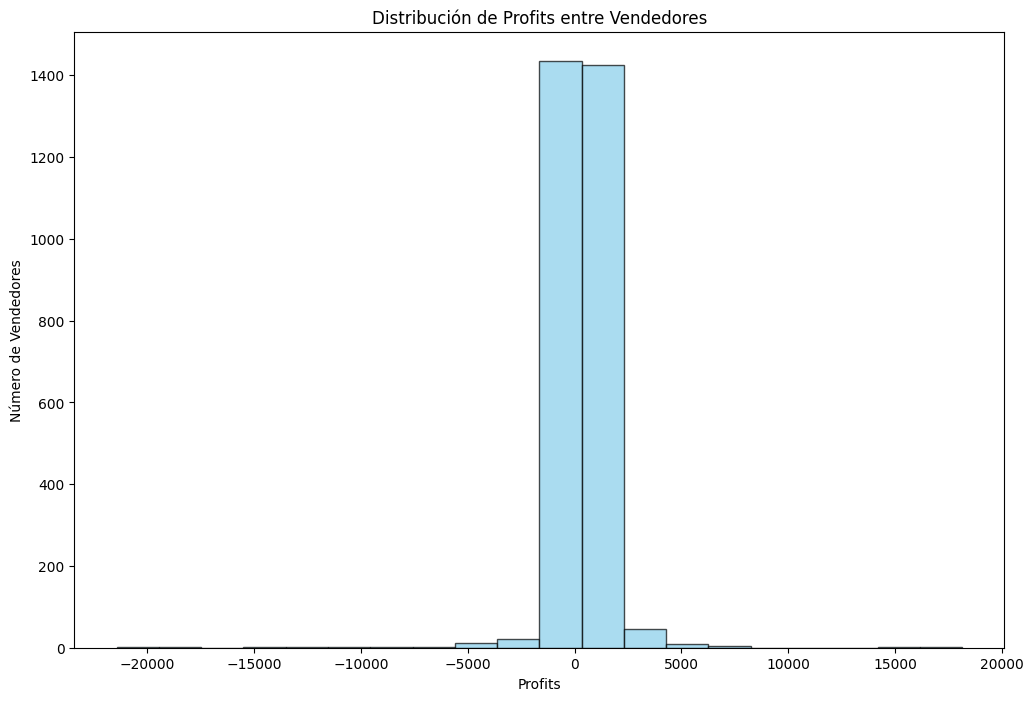

In [80]:
plt.figure(figsize=(12, 8))
plt.hist(sellers_data['profits'], bins=20, edgecolor='black', color='skyblue', alpha=0.7)
plt.xlabel('Profits')
plt.ylabel('Número de Vendedores')
plt.title('Distribución de Profits entre Vendedores')

In [71]:
optimal_index = np.argmax(sellers_data['cumulative_net_profit'])
optimal_sellers_data = sellers_data.iloc[optimal_index]

print(f"Número óptimo de vendedores para maximizar ganancias netas: {optimal_index + 1}")
print(f"Ganancia neta máxima: {optimal_sellers_data['cumulative_net_profit']}")

Número óptimo de vendedores para maximizar ganancias netas: 2696
Ganancia neta máxima: 1268403.4346591232


In [66]:
low_performance_threshold = sellers_data['profits'].quantile(0.25)
low_performance_threshold

100.98

In [67]:
low_performance_sellers = sellers_data[sellers_data['profits'] <= low_performance_threshold]
low_performance_sellers

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,...,n_orders,quantity,quantity_per_order,sales,revenues,profits,cumulative_profits,cumulative_items,cumulative_it_costs,cumulative_net_profit
2129,269c5fc9fcadee614364c3620c30a1f9,guarulhos,SP,0.00000,4.606663,2018-07-31 19:31:32,2018-08-08 21:30:12,0.0,0.000000,1.000000,...,3,6,2.000000,209.60,100.960,100.960,1648842.606,66658,401523.073100,1.247320e+06
2588,3fefda3299e6dfaea3466ef346a3571a,curitiba,PR,0.00000,6.314271,2017-08-12 02:55:27,2017-08-12 02:55:27,0.0,0.000000,0.000000,...,1,1,1.000000,209.00,100.900,100.900,1648943.506,66659,401558.423270,1.247385e+06
2352,5a9c0859cb00fd8aa4db443837f0a700,treze tilias,SC,0.00000,9.005376,2018-07-09 17:45:00,2018-07-11 19:55:20,0.0,0.000000,0.500000,...,2,2,1.000000,208.00,100.800,100.800,1649044.306,66661,401595.660338,1.247449e+06
637,20a8b0dc55da94fe74d112082427c84f,itu,SP,0.00000,8.235255,2018-07-31 13:24:24,2018-08-23 11:30:31,1.0,0.142857,0.714286,...,7,7,1.000000,407.40,200.740,100.740,1649145.046,66668,401642.361597,1.247503e+06
1599,efb628aa07c8ca93d7db0d85b91a4f5a,nova iguacu,RJ,0.35838,25.588310,2017-11-17 09:06:57,2017-11-17 09:06:57,0.0,0.000000,0.000000,...,1,1,1.000000,204.00,100.400,100.400,1649245.446,66669,401677.689108,1.247568e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,8b321bb669392f5163d04c59e235e066,sao paulo,SP,0.00000,12.616899,2017-10-27 16:31:30,2018-08-21 17:08:38,10.0,0.118211,0.568690,...,943,1018,1.079533,17535.69,2633.569,-12806.431,1477044.075,105443,489511.812301,9.875323e+05
945,ea8482cd71df3c1969d7b9473ff13abc,sao paulo,SP,0.00000,13.315562,2017-08-16 15:15:26,2018-08-25 02:45:21,12.0,0.113935,0.527607,...,1146,1203,1.049738,37177.52,4757.752,-15462.248,1461581.827,106646,491347.711731,9.702341e+05
1357,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.00000,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,19.0,0.116092,0.584483,...,1706,1775,1.040445,104288.42,12028.842,-17501.158,1444080.669,108421,494024.237152,9.500564e+05
2358,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,0.00000,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,20.0,0.143809,0.482510,...,1806,1987,1.100221,200472.92,21727.292,-17672.708,1426407.961,110408,496991.389117,9.294166e+05


In [68]:
profitable_sellers = sellers_data[sellers_data['profits'] > low_performance_threshold]
profitable_sellers

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,...,n_orders,quantity,quantity_per_order,sales,revenues,profits,cumulative_profits,cumulative_items,cumulative_it_costs,cumulative_net_profit
868,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,0.0,13.374429,2017-08-28 18:44:58,2018-08-21 16:35:26,12.0,0.095506,0.561798,...,358,410,1.145251,222776.05,23317.605,18147.605,18147.605,410,22964.917828,-4.817313e+03
67,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,21.0,0.101493,0.629851,...,336,340,1.011905,176431.87,19403.187,14703.187,32850.792,750,31254.985925,1.595806e+03
534,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,0.086059,0.676420,...,585,586,1.001709,194042.03,21084.203,14574.203,47424.995,1336,41224.163282,6.200832e+03
2151,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.0,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,11.0,0.066265,0.692771,...,166,175,1.054217,79284.55,8888.455,7368.455,54793.450,1511,44339.889079,1.045356e+04
2830,46dc3b2cc0980fb8ec44634e21d2718e,rio de janeiro,RJ,0.0,11.800424,2016-10-06 15:44:00,2018-08-17 22:49:38,22.0,0.112621,0.629126,...,521,542,1.040307,128111.19,14651.119,7151.119,61944.569,2053,51383.513743,1.056106e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1894,68ca56ce86830f3d31b1b7ec6a54da3e,guaratuba,PR,0.0,4.891428,2018-07-11 18:30:12,2018-08-10 18:25:16,1.0,0.000000,0.500000,...,6,6,1.000000,719.59,231.959,101.959,1648335.798,66637,401315.894925,1.247020e+06
2203,751e274377499a8503fd6243ad9c56f6,campinas,SP,0.0,1.997465,2018-08-20 22:29:24,2018-08-20 22:29:24,0.0,0.000000,1.000000,...,1,2,2.000000,218.00,101.800,101.800,1648437.598,66639,401353.177757,1.247084e+06
2126,dc7192adf8ba09569261f4a8d576afe0,itapeva,SP,0.0,6.325258,2018-07-23 12:31:51,2018-08-22 19:04:28,1.0,0.142857,0.571429,...,7,8,1.142857,917.00,251.700,101.700,1648539.298,66647,401401.820935,1.247137e+06
951,042573af89b6d931f672efaf789d8358,sorocaba,SP,0.0,20.024784,2018-01-22 13:55:27,2018-02-11 13:28:20,1.0,0.333333,0.666667,...,3,3,1.000000,413.48,201.348,101.348,1648640.646,66650,401440.982994,1.247200e+06


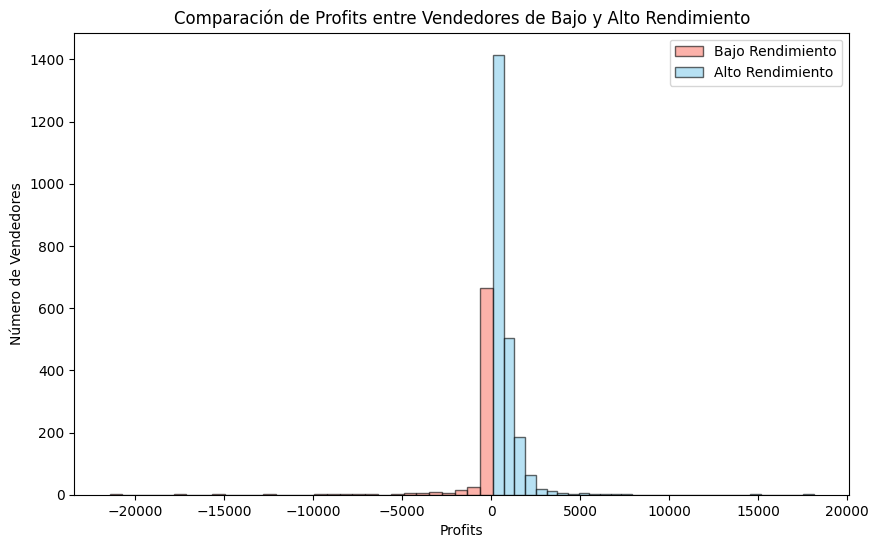

In [75]:
plt.figure(figsize=(10, 6))
plt.hist(low_performance_sellers['profits'], bins=30, edgecolor='black', color='salmon', alpha=0.6, label='Bajo Rendimiento')
plt.hist(profitable_sellers['profits'], bins=30, edgecolor='black', color='skyblue', alpha=0.6, label='Alto Rendimiento')
plt.xlabel('Profits')
plt.ylabel('Número de Vendedores')
plt.title('Comparación de Profits entre Vendedores de Bajo y Alto Rendimiento')
plt.legend()
plt.show()

In [69]:
total_profits = sellers_data['profits'].sum()
low_performance_profits = low_performance_sellers['profits'].sum()
profitable_profits = profitable_sellers['profits'].sum()

In [76]:
print(f"Perdidas generadas por vendedores de bajo rendimiento: {low_performance_profits} ({(low_performance_profits / total_profits) * 100:.2f}%)")
print(f"Ganancias de vendedores de alto rendimiento: {profitable_profits} ({(profitable_profits / total_profits) * 100:.2f}%)")

Perdidas generadas por vendedores de bajo rendimiento: -243773.202 (-17.35%)
Ganancias de vendedores de alto rendimiento: 1648741.646 (117.35%)


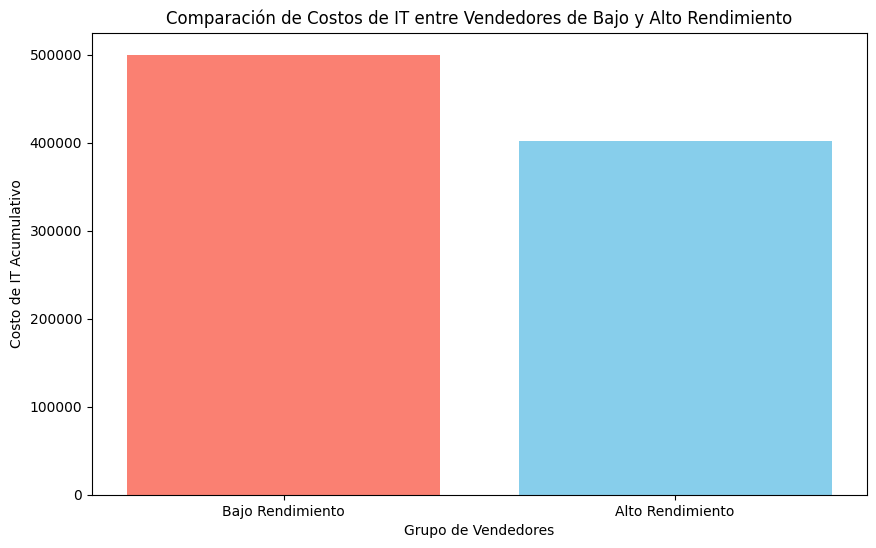

In [77]:
categories = ['Bajo Rendimiento', 'Alto Rendimiento']
it_costs = [low_performance_sellers['cumulative_it_costs'].iloc[-1], profitable_sellers['cumulative_it_costs'].iloc[-1]]
plt.figure(figsize=(10, 6))
plt.bar(categories, it_costs, color=['salmon', 'skyblue'])
plt.xlabel('Grupo de Vendedores')
plt.ylabel('Costo de IT Acumulativo')
plt.title('Comparación de Costos de IT entre Vendedores de Bajo y Alto Rendimiento')
plt.show()

## 3. Investigate other Approaches 🕵️
*(optional)*

- Should Olist remove the worst performing products / categories from its marketplace entirely?
- Should Olist remove only consistently underperforming sellers, after a honeymoon period of a few months?
- Should Olist enforce sellers to include certain information on their product listings?
- Should Olist ask customers for purchase confirmation at certain times of day?
- Should Olist restrict seller/customer pairs between certain states to avoid delays?
- Should Olist acquire new sellers, with some cost assumptions to be suggested?
- ...


## Your turn!

🧺 Keep this notebook tidy! 

🗣 📊 You will present your insights to your favorite TA at the end of this `Communicate` unit 💪